### Phase 1 Code: The Generator & Visualizer

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# --- 1. Sudoku Logic Helpers ---
def get_pattern(r, c): return (3 * (r % 3) + r // 3 + c) % 9

def shuffle(s): return random.sample(s, len(s)) 

def generate_solution_base():
    """Generates a valid full 9x9 Sudoku grid using randomized shifting."""
    rBase = range(3) 
    rows  = [g * 3 + r for g in shuffle(rBase) for r in shuffle(rBase)] 
    cols  = [g * 3 + c for g in shuffle(rBase) for c in shuffle(rBase)]
    nums  = shuffle(range(1, 10))
    
    # Produce board using randomized baseline pattern
    board = [[nums[get_pattern(r, c)] for c in cols] for r in rows]
    return torch.tensor(board, dtype=torch.long)


In [2]:

def mask_board(solution, difficulty=0.5):
    """
    Removes numbers to create the puzzle.
    difficulty: Percentage of items to remove (0.0 to 1.0)
    """
    puzzle = solution.clone()
    # Flatten, mask random indices, reshape
    flat = puzzle.flatten()
    num_masked = int(81 * difficulty)
    mask_indices = torch.randperm(81)[:num_masked]
    flat[mask_indices] = 0 # 0 represents 'Empty'
    return flat.view(9, 9)

# --- 2. The Batch Factory ---
class SudokuFactory:
    def __init__(self):
        pass
        
    def get_batch(self, batch_size=16, difficulty=0.4):
        """
        Returns:
            inputs: (B, 81) LongTensor (0-9, where 0 is empty)
            targets: (B, 81) LongTensor (1-9, fully solved)
        """
        inputs = []
        targets = []
        
        for _ in range(batch_size):
            sol = generate_solution_base()
            puz = mask_board(sol, difficulty)
            
            inputs.append(puz.flatten())
            targets.append(sol.flatten())
            
        return torch.stack(inputs), torch.stack(targets)


In [3]:

# --- 3. Visualization Tool (Side-by-Side) ---
def plot_sudoku(input_grid, target_grid=None, title="Sudoku"):
    """
    Visualizes the input vs target.
    Expects 1D tensors of shape (81,) or 2D (9,9)
    """
    fig, axes = plt.subplots(1, 2 if target_grid is not None else 1, figsize=(8, 4))
    if target_grid is None: axes = [axes]
    
    grids = [(input_grid, "Input (Puzzle)")]
    if target_grid is not None:
        grids.append((target_grid, "Target (Solution)"))
        
    for ax, (grid, label) in zip(axes, grids):
        grid = grid.view(9, 9).cpu().numpy()
        ax.matshow(grid, cmap='Blues', vmin=0, vmax=9)
        
        # Draw grid lines
        for i in range(10):
            lw = 2 if i % 3 == 0 else 0.5
            ax.axhline(i - 0.5, color='black', linewidth=lw)
            ax.axvline(i - 0.5, color='black', linewidth=lw)
            
        # Fill numbers
        for i in range(9):
            for j in range(9):
                val = grid[i, j]
                if val != 0:
                    ax.text(j, i, str(val), ha='center', va='center', fontsize=12)
                    
        ax.set_title(label)
        ax.axis('off')
    plt.show()


Input Shape: torch.Size([4, 81])
Target Shape: torch.Size([4, 81])


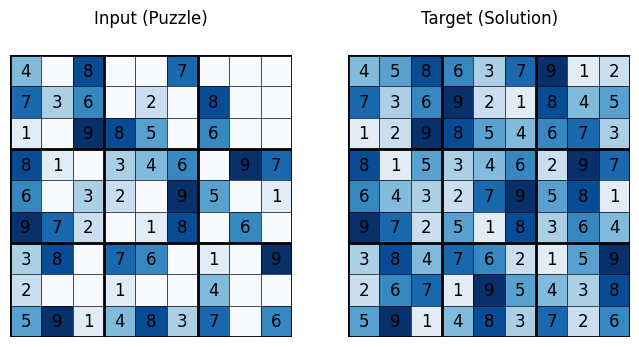

In [4]:

# --- 4. Test It ---
factory = SudokuFactory()
x, y = factory.get_batch(batch_size=4)

print(f"Input Shape: {x.shape}")   # Should be [4, 81]
print(f"Target Shape: {y.shape}")  # Should be [4, 81]

# Plot the first example in the batch
plot_sudoku(x[0], y[0])

### Implementing TRM

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class TRM_Sudoku(nn.Module):
    def __init__(self, hidden_dim=256, recursions=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.recursions = recursions # How many times to loop
        
        # --- 1. Embeddings ---
        # Numbers 0-9 (10 tokens). 0 is 'Empty'.
        self.token_embedding = nn.Embedding(10, hidden_dim)
        
        # Positional Encoding: Sudoku is spatial. The model needs to know
        # that cell 0 is top-left and cell 80 is bottom-right.
        self.pos_embedding = nn.Parameter(torch.randn(1, 81, hidden_dim) * 0.02)
        
        # --- 2. The Tiny Brain (MLP) ---
        # Input size: Hidden (for x) + Hidden (for y) + Hidden (for z) = 3 * Hidden
        # We concatenate them all together.
        self.net = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.GELU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        
        # --- 3. The Output Heads ---
        # Head to predict the actual number (Logits for 1-9)
        # Note: We predict 1-9 directly. 0 is input-only.
        self.to_logits = nn.Linear(hidden_dim, 9) 

    def forward(self, x_input, targets=None):
        """
        x_input: (B, 81) LongTensor (The puzzle)
        targets: (B, 81) LongTensor (The solution, optional for training labels)
        """
        B, L = x_input.shape
        
        # --- A. Initialization ---
        # Embed the static puzzle x
        x_emb = self.token_embedding(x_input) + self.pos_embedding
        
        # Initialize y (Draft) and z (Reasoning) with zeros/noise
        # In a real run, y starts as the input puzzle (with 0s)
        # For simplicity, we can start y as a copy of x
        y_emb = x_emb.clone()
        z_emb = torch.zeros_like(x_emb) # Blank reasoning slate
        
        all_drafts = [] # Store history for Deep Supervision
        
        # --- B. The Loop (Recursion) ---
        for step in range(self.recursions):
            
            # 1. Combine inputs: (x, y, z)
            # We concat along the feature dimension
            combined = torch.cat([x_emb, y_emb, z_emb], dim=-1) # (B, 81, 3*H)
            
            # 2. Run the Tiny Brain
            # The network updates 'z' (reasoning state)
            z_emb = self.net(combined) + z_emb # Residual connection!
            
            # 3. Update 'y' (The Answer Draft) based on new 'z'
            # In the paper, they sometimes reuse the net or use a head.
            # Here, we treat z_emb effectively as the "next y embedding" 
            # but we need to convert it back to token space to get probabilities.
            logits = self.to_logits(z_emb) # (B, 81, 9)
            
            # 4. Soft Update of y_emb
            # Instead of taking argmax (hard update), we keep y differentiable.
            # We take the probabilities and multiply by the embedding matrix.
            probs = F.softmax(logits, dim=-1) # (B, 81, 9)
            
            # Use the embeddings for 1-9 (indices 1..9)
            # This is "Softmax Gumbel" trick logic roughly
            tokens_1_to_9 = self.token_embedding.weight[1:10] # (9, H)
            y_emb = probs @ tokens_1_to_9 # (B, 81, 9) @ (9, H) -> (B, 81, H)
            
            # Add position info back to y so it doesn't get lost
            y_emb = y_emb + self.pos_embedding
            
            # Store logits for loss calculation
            all_drafts.append(logits)
            
        return all_drafts # List of [Step 1 Logits, Step 2 Logits, ...]

In [6]:
import torch.optim as optim

# --- 1. Hyperparameters ---
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 1000 # Short run for POC (Paper uses 100k+)
RECURSIONS = 8 # How deep to think
HIDDEN_DIM = 128

# --- 2. Setup ---
# Re-init factory and model
factory = SudokuFactory()
model = TRM_Sudoku(hidden_dim=HIDDEN_DIM, recursions=RECURSIONS)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# --- 3. The Training Loop ---
loss_history = []
acc_history = {i: [] for i in range(RECURSIONS)} # Track accuracy per step

print(f"Starting training on simple Sudoku generation...")


Starting training on simple Sudoku generation...


In [7]:

for epoch in range(EPOCHS):
    # A. Get Data
    # inputs: (B, 81), targets: (B, 81)
    inputs, targets = factory.get_batch(batch_size=BATCH_SIZE)
    
    # Adjust targets for CrossEntropy
    # The model predicts 1-9 (indices 0-8). Target values are 1-9.
    # So we need target indices 0-8.
    # We subtract 1 from targets. 0s in input (empty) don't matter for target (it's fully solved)
    target_indices = targets - 1 
    
    # B. Forward Pass
    optimizer.zero_grad()
    
    # The model returns a list of logits: [Step1, Step2, ..., Step8]
    all_drafts = model(inputs) 
    
    # C. Deep Supervision Loss
    total_loss = 0
    
    for step_i, draft_logits in enumerate(all_drafts):
        # draft_logits: (B, 81, 9) -> Need (B*81, 9) for Loss
        # target_indices: (B, 81) -> Need (B*81)
        
        loss_step = criterion(
            draft_logits.reshape(-1, 9), 
            target_indices.reshape(-1)
        )
        
        total_loss += loss_step
        
        # --- Tracking Accuracy ---
        with torch.no_grad():
            # Get predicted numbers (0-8) + 1 = (1-9)
            preds = draft_logits.argmax(dim=-1) + 1
            # Compare to true targets
            correct = (preds == targets).float().mean().item()
            acc_history[step_i].append(correct)
    
    # D. Backprop
    total_loss.backward()
    optimizer.step()
    
    loss_history.append(total_loss.item())
    
    # E. Status Update
    if epoch % 100 == 0:
        # Print accuracy of First Step vs Last Step
        acc_first = acc_history[0][-1] * 100
        acc_last = acc_history[RECURSIONS-1][-1] * 100
        print(f"Epoch {epoch:4d} | Loss: {total_loss.item():.4f} | "
              f"Thinking Acc: Step 1: {acc_first:.1f}% -> Step {RECURSIONS}: {acc_last:.1f}%")

print("Training Complete.")

Epoch    0 | Loss: 43.9966 | Thinking Acc: Step 1: 10.7% -> Step 8: 4.7%
Epoch  100 | Loss: 6.9902 | Thinking Acc: Step 1: 64.7% -> Step 8: 64.6%
Epoch  200 | Loss: 6.9695 | Thinking Acc: Step 1: 65.1% -> Step 8: 65.2%
Epoch  300 | Loss: 6.9648 | Thinking Acc: Step 1: 65.4% -> Step 8: 64.9%
Epoch  400 | Loss: 7.0020 | Thinking Acc: Step 1: 65.0% -> Step 8: 65.0%
Epoch  500 | Loss: 6.9706 | Thinking Acc: Step 1: 65.0% -> Step 8: 64.4%
Epoch  600 | Loss: 6.9633 | Thinking Acc: Step 1: 65.3% -> Step 8: 65.2%
Epoch  700 | Loss: 6.9598 | Thinking Acc: Step 1: 65.1% -> Step 8: 64.9%
Epoch  800 | Loss: 6.9613 | Thinking Acc: Step 1: 65.0% -> Step 8: 65.0%
Epoch  900 | Loss: 6.9680 | Thinking Acc: Step 1: 64.6% -> Step 8: 65.0%
Training Complete.


In [8]:
import matplotlib.pyplot as plt

# --- 1. The "Film Strip" Visualization ---
def visualize_thinking(model, factory, specific_step_indices=[0, 2, 4, 7]):
    """
    Plots: Input -> Step 1 -> Step 3 -> ... -> Final -> Target
    """
    model.eval()
    
    # Get 1 example
    x, y = factory.get_batch(batch_size=1)
    
    with torch.no_grad():
        # Get all 8 drafts
        all_drafts = model(x)
        
    # Convert logits to numbers (1-9)
    # drafts is a list of tensors. We pick specific steps to visualize.
    predictions = []
    for i in specific_step_indices:
        # Draft shape: (1, 81, 9) -> argmax -> (1, 81) -> add 1 -> reshape (9,9)
        pred_grid = (all_drafts[i].argmax(dim=-1) + 1).view(9, 9)
        predictions.append((pred_grid, f"Draft Step {i+1}"))
        
    # Prepare plot list: Input -> [Drafts] -> Target
    plots_to_show = [(x.view(9,9), "Input")] + predictions + [(y.view(9,9), "Target")]
    
    # Drawing
    fig, axes = plt.subplots(1, len(plots_to_show), figsize=(15, 3))
    
    for ax, (grid, title) in zip(axes, plots_to_show):
        g_np = grid.cpu().numpy()
        ax.matshow(g_np, cmap='Blues', vmin=0, vmax=9)
        
        # Add numbers
        for r in range(9):
            for c in range(9):
                val = g_np[r, c]
                if val != 0: # Don't draw 0s
                    # Highlight errors? 
                    # Optional: Check against target if it's a Draft
                    color = 'black'
                    ax.text(c, r, str(val), ha='center', va='center', color=color)
        
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


In [9]:
# --- 2. The "Thinking Curve" Graph ---
def plot_accuracy_curve(acc_history):
    """
    Shows how accuracy improves over the recursion steps (1 to 8).
    Uses the data from the LAST epoch of training.
    """
    # Safety Check: Ensure we actually have data
    if not acc_history or len(acc_history[0]) == 0:
        print("⚠️ No training data found! Did you run the training loop in Phase 3?")
        return

    steps = sorted(acc_history.keys())
    final_accs = [acc_history[s][-1] * 100 for s in steps] # Last recorded accuracy
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(steps)+1), final_accs, marker='o', linestyle='-', color='green', linewidth=2)
    
    plt.title("The Benefit of Thinking (Recursion)")
    plt.xlabel("Reasoning Step (Recursion Depth)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, len(steps)+1))
    
    # Add label to the jump
    improvement = final_accs[-1] - final_accs[0]
    plt.text(len(steps)/2, min(final_accs) + improvement/2, 
             f"+{improvement:.1f}% Improvement", 
             fontsize=12, color='green', fontweight='bold')
    
    plt.show()

Visualizing the Thinking Process...


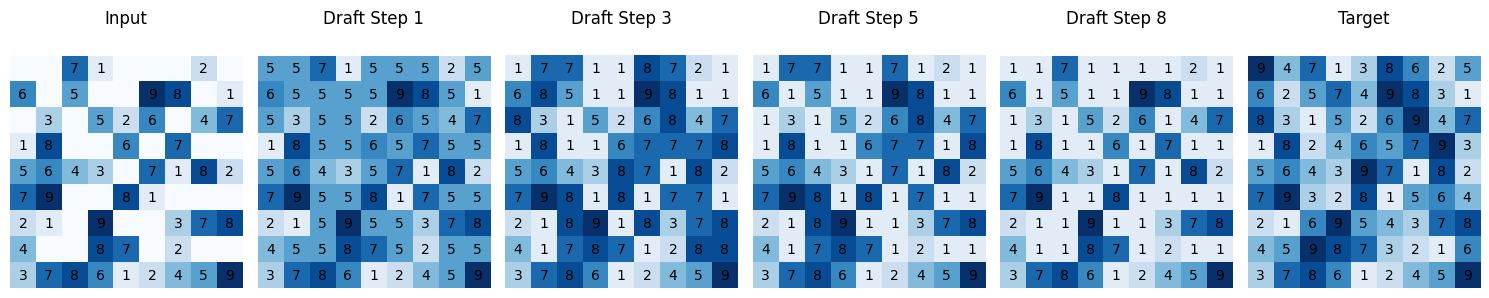

In [10]:

# --- 3. Run Analysis ---
print("Visualizing the Thinking Process...")
visualize_thinking(model, factory)


Plotting the Thinking Curve...


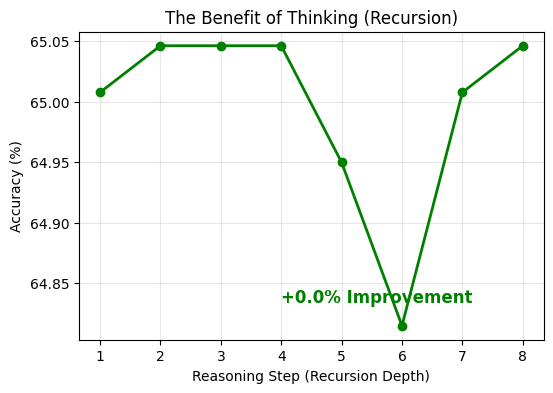

In [12]:

print("Plotting the Thinking Curve...")
plot_accuracy_curve(acc_history)

In [22]:
def compare_recursion_performance(model, factory, test_size=100):
    model.eval()
    
    # 1. Generate a fresh Test Set
    print(f"Generating {test_size} new puzzles for testing...")
    inputs, targets = factory.get_batch(batch_size=test_size)
    
    with torch.no_grad():
        # Run the model to get all steps
        all_drafts = model(inputs)
        
    # 2. Extract "No Recursion" (Step 1) vs "With Recursion" (Step 8)
    # Output format: List of tensors, each (Batch, 81, 9)
    
    # --- Step 1 (Standard Feed-Forward) ---
    step1_logits = all_drafts[0] 
    step1_preds = step1_logits.argmax(dim=-1) + 1 # Convert logits to 1-9
    
    # --- Step 8 (Recursive/Refined) ---
    step8_logits = all_drafts[-1]
    step8_preds = step8_logits.argmax(dim=-1) + 1
    
    # 3. Calculate Accuracy
    # We compare against the known solution 'targets'
    
    # Pixel-wise accuracy (How many individual cells are correct?)
    acc_no_rec = (step1_preds == targets).float().mean().item() * 100
    acc_with_rec = (step8_preds == targets).float().mean().item() * 100
    
    # Puzzle-wise accuracy (How many FULL puzzles are 100% correct?)
    # We sum equality along the grid dimension (dim 1). If sum == 81, it's perfect.
    perfect_no_rec = ((step1_preds == targets).sum(dim=1) == 81).float().mean().item() * 100
    perfect_with_rec = ((step8_preds == targets).sum(dim=1) == 81).float().mean().item() * 100
    
    # 4. Report Results
    print("-" * 40)
    print(f"RESULTS (On {test_size} unseen puzzles)")
    print("-" * 40)
    print(f"WITHOUT Recursion (Step 1):")
    print(f"  - Cell Accuracy:   {acc_no_rec:.2f}%")
    print(f"  - Perfect Puzzles: {perfect_no_rec:.1f}% solved")
    print(f"\nWITH Recursion (Step 8):")
    print(f"  - Cell Accuracy:   {acc_with_rec:.2f}%")
    print(f"  - Perfect Puzzles: {perfect_with_rec:.1f}% solved")
    print("-" * 40)
    print(f"GAIN: +{perfect_with_rec - perfect_no_rec:.1f}% more puzzles solved by thinking.")
    
    # 5. Visual Proof (Find a puzzle where Step 1 failed but Step 8 succeeded)
    # Find index where Step 1 != Target but Step 8 == Target
    solved_indices = ((step8_preds == targets).sum(dim=1) == 81)
    failed_indices = ((step1_preds == targets).sum(dim=1) < 81)
    improved_indices = torch.where(solved_indices & failed_indices)[0]
    
    if len(improved_indices) > 0:
        idx = improved_indices[0]
        print(f"\nVisualizing Example #{idx}: The 'Aha!' Moment")
        plot_sudoku(step1_preds[idx], step8_preds[idx], title=f"Step 1 (Wrong) vs Step 8 (Correct)")
    else:
        print("\nCould not find a dramatic 'fix' example in this batch (maybe model is too good or too bad).")

# Run the comparison
compare_recursion_performance(model, factory)

Generating 100 new puzzles for testing...
----------------------------------------
RESULTS (On 100 unseen puzzles)
----------------------------------------
WITHOUT Recursion (Step 1):
  - Cell Accuracy:   64.38%
  - Perfect Puzzles: 0.0% solved

WITH Recursion (Step 8):
  - Cell Accuracy:   65.16%
  - Perfect Puzzles: 0.0% solved
----------------------------------------
GAIN: +0.0% more puzzles solved by thinking.

Could not find a dramatic 'fix' example in this batch (maybe model is too good or too bad).


Starting Curriculum Training...
Epoch 0 | Diff: 0.10 | Loss: 44.10 | Acc: 11.5% -> 0.9%
Epoch 500 | Diff: 0.15 | Loss: 2.63 | Acc: 86.6% -> 86.6%
Epoch 1000 | Diff: 0.20 | Loss: 3.48 | Acc: 82.3% -> 82.5%
Epoch 1500 | Diff: 0.25 | Loss: 4.37 | Acc: 78.0% -> 78.0%
Epoch 2000 | Diff: 0.30 | Loss: 5.21 | Acc: 74.1% -> 74.1%
Epoch 2500 | Diff: 0.35 | Loss: 6.10 | Acc: 69.4% -> 69.4%
Epoch 3000 | Diff: 0.40 | Loss: 6.99 | Acc: 64.5% -> 64.5%
Epoch 3500 | Diff: 0.45 | Loss: 7.83 | Acc: 60.5% -> 60.4%
Epoch 4000 | Diff: 0.50 | Loss: 8.70 | Acc: 56.1% -> 55.8%
Epoch 4500 | Diff: 0.55 | Loss: 9.56 | Acc: 51.5% -> 51.9%


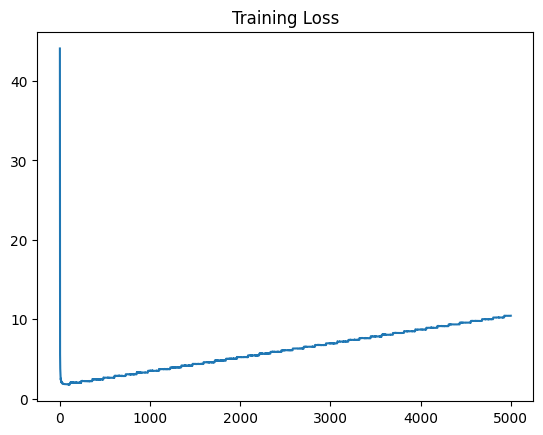

In [23]:
# --- Improved Phase 3: Curriculum Training ---
import matplotlib.pyplot as plt

# 1. Setup
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 5000  # Increased from 1000
RECURSIONS = 8

model = TRM_Sudoku(hidden_dim=128, recursions=RECURSIONS)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
factory = SudokuFactory()

loss_history = []

print("Starting Curriculum Training...")

for epoch in range(EPOCHS):
    # --- CURRICULUM: Easy -> Hard ---
    # Epoch 0    -> 10% masked (Very Easy)
    # Epoch 2500 -> 35% masked (Medium)
    # Epoch 5000 -> 60% masked (Hard)
    progress = epoch / EPOCHS
    difficulty = 0.1 + (0.5 * progress) 
    
    # Get Batch
    # inputs: (B, 81), targets: (B, 81)
    # Note: We need to modify factory.get_batch to accept difficulty if you haven't yet
    # Assuming you updated factory.get_batch(batch_size, difficulty)
    inputs, targets = factory.get_batch(batch_size=BATCH_SIZE, difficulty=difficulty)
    target_indices = targets - 1

    optimizer.zero_grad()
    all_drafts = model(inputs)
    
    # --- Deep Supervision with "Weighted" Loss ---
    # Tip: Give more weight to the final answer to encourage convergence
    total_loss = 0
    for step_i, draft_logits in enumerate(all_drafts):
        step_loss = criterion(draft_logits.reshape(-1, 9), target_indices.reshape(-1))
        
        # Weight later steps slightly more? 
        # For now, uniform weight is fine, but let's just sum them.
        total_loss += step_loss
    
    total_loss.backward()
    optimizer.step()
    
    loss_history.append(total_loss.item())

    if epoch % 500 == 0:
        # Check Step 1 vs Step 8 on this batch
        with torch.no_grad():
            acc_1 = (all_drafts[0].argmax(-1) == target_indices).float().mean()
            acc_8 = (all_drafts[-1].argmax(-1) == target_indices).float().mean()
            print(f"Epoch {epoch} | Diff: {difficulty:.2f} | Loss: {total_loss.item():.2f} | "
                  f"Acc: {acc_1*100:.1f}% -> {acc_8*100:.1f}%")

# Plot Loss to verify learning
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()